# Plotting of along-slope velocity transformed into ASC coordinate system 

This scripts plots daily along-slope velocity data that were transformed into an ASC coordinate system. The transformation is done in `Calc_ASCcoord_transform_ocean.ipynb`.

We use the ASC regimes as defined in `Calc_ASC_regimes.ipynb` to highlight different regions.

In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
from dask.distributed import Client

# Optional modules
import cmocean as cm
import matplotlib.gridspec as gridspec

# Ignore warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

Start a cluster with multiple cores

In [2]:
client = Client() # n_workers=4
client

<Client: 'tcp://127.0.0.1:41675' processes=4 threads=16, memory=44.92 GiB>

### Load in pre-calculated velocity data

In [3]:
file_path = '/g/data/x77/wgh581/Post_Process/'
file_name = 'transects_binned_daily_full_dropna.nc'

ds = xr.open_dataarray(file_path + file_name)

Barotropic velocity

In [4]:
# Load database
session = cc.database.create_session()
# Define experiment in database
expt = '01deg_jra55v13_ryf9091'

In [5]:
# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(expt, 'st_edges_ocean', session, n=1) # , start_time=start_time, end_time=end_time.
st_edges_array = st_edges_ocean.expand_dims({'lon_shelf':ds.lon_shelf, 'depth_bin':ds.depth_bin}, axis=[1,2])

# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ds.depth_bin, other=ds.depth_bin)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(expt, 'st_ocean', session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))
thickness = thickness

# We only need values down to the deepest depth_bin
st_ocean_slice = slice(0, 2000)
thickness = thickness.sel(st_ocean = st_ocean_slice)

In [6]:
ds_barotropic = (ds * thickness).sum('st_ocean') / thickness.sum('st_ocean')

Bottom velocity

In [7]:
# Array that has the depth levels
depth_array_1 = ds[:,0,:,:] * 0 + ds.st_ocean

# Get max depth of data (skipping nans)
max_depth_1   = depth_array_1.max(dim='st_ocean', skipna=True) 

# Select the bottom using max_depth: bottom is where the depth level is larger/equal the max depth
ds_bottom = ds.where(depth_array_1.st_ocean >= max_depth_1)
ds_bottom = ds_bottom.sum(dim='st_ocean')

Surface velocity

In [8]:
ds_surface = ds[:,:,0,:]

Surface 200 m average

In [9]:
ds_surface_200m = ds.sel(st_ocean=slice(0, 200))
thickness_200m  = thickness.sel(st_ocean=slice(0, 200))
ds_surface_200m = (ds_surface_200m * thickness_200m).sum('st_ocean') / thickness_200m.sum('st_ocean')

Set values out of range to nan

In [10]:
ds_barotropic = ds_barotropic.where(ds_barotropic != 0)
ds_barotropic = ds_barotropic.where(ds_barotropic <= 1)
ds_barotropic = ds_barotropic.where(ds_barotropic >= -1)

ds_bottom = ds_bottom.where(ds_bottom != 0)
ds_bottom = ds_bottom.where(ds_bottom <= 1)
ds_bottom = ds_bottom.where(ds_bottom >= -1)

ds_surface = ds_surface.where(ds_surface != 0)
ds_surface = ds_surface.where(ds_surface <= 1)
ds_surface = ds_surface.where(ds_surface >= -1)

ds_surface_200m = ds_surface_200m.where(ds_surface_200m != 0)
ds_surface_200m = ds_surface_200m.where(ds_surface_200m <= 1)
ds_surface_200m = ds_surface_200m.where(ds_surface_200m >= -1)

### More infos used in various plots

First, remove lon/lat values from 630-m isobath that got removed as some transects had bumps.

In [11]:
in_file  = '/g/data/x77/wgh581/Post_Process/' + 'Antarctic_slope_transects_630m_2000m.npz'
in_data  = np.load(in_file)
lon_630m = in_data['lon_630m']
lat_630m = in_data['lat_630m']

In [12]:
index_nan = []
lon_shelf_nan = ds.lon_shelf.values
for ii in range(len(lon_630m)):
    if (lon_630m[ii] - lon_shelf_nan[ii]) != 0:
        lon_shelf_nan = np.insert(lon_shelf_nan, ii, lon_630m[ii])
        index_nan.append(ii)
index_nan = index_nan[::-1]

In [13]:
lon_630m_dropna = lon_630m.tolist()
lat_630m_dropna = lat_630m.tolist()
for ii in range(len(index_nan)):
    del lon_630m_dropna[index_nan[ii]]
    del lat_630m_dropna[index_nan[ii]]

Distance along the 1-km isobath

In [14]:
def gcdist(lat1, lat2, lon1, lon2):

    # Radius of the Earth in km
    r = 6371
    # Difference between points (lon/lat)
    dlon = lon2-lon1
    dlat = lat2-lat1
    # Calculate distance in km
    gcdist = r * np.deg2rad(np.sqrt(dlat**2 + (dlon*np.cos(np.deg2rad(np.mean([lat1,lat2]))))**2))

    return gcdist

In [15]:
distance_along_contour = np.zeros((len(ds.lon_shelf)))
for ii in range(len(ds.lon_shelf)-1):
    lat1 = lat_630m_dropna[ii]
    lat2 = lat_630m_dropna[ii+1]
    lon1 = lon_630m_dropna[ii]
    lon2 = lon_630m_dropna[ii+1]
    distance_along_contour[ii+1] = gcdist(lat1, lat2, lon1, lon2)
distance_along_contour_cumsum = distance_along_contour.cumsum()

ASC regimes

In [50]:
# Load ASC classification (calculated in Calc_ASC_classification.ipynb)
file_path   = '/g/data/x77/wgh581/Post_Process/'
file_name   = 'ASC_regimes_01deg_jra55v13_ryf9091_plt_approach_smoothed_btm200m_50.npz'
ASC_regimes = np.load(file_path + file_name)
ASC_regimes = ASC_regimes['ASC_regimes_annual']
ASC_regimes_2d = np.vstack((ASC_regimes, ASC_regimes))

In [17]:
# Load lon/lat on 1km isobath, u-grid
file_name = 'Antarctic_slope_contour_1km_velocities_plt_approach.npz'
data = np.load(file_path + file_name)
#data.files
lon_along_contour = data['lon_along_contour']
lat_along_contour = data['lat_along_contour']

In [18]:
# Indeces with ASC regime information
var = np.diff(ASC_regimes)
index_tmp = [0]
ASC_tmp   = []
lon_test  = []
lat_test  = []
for ii in range(len(var)):
    if var[ii] != 0:
        lon_tmp = lon_along_contour[ii]
        lat_tmp = lat_along_contour[ii]
        index_tmp.append( np.argmin((lon_630m_dropna - lon_tmp)**2 + (lat_630m_dropna - lat_tmp)**2) )
        ASC_tmp.append(ASC_regimes[ii-1])
        lon_test.append(lon_tmp)
        lat_test.append(lat_tmp)
ASC_tmp.append(0)
index_tmp.append(len(ds.lon_shelf.values))

In [19]:
index_tmp[7] = 1960
index_tmp[8] = 1960

In [20]:
# Variable with regime info (one of: 0, 1, 2)
ASC_regimes_binned =  np.zeros(len(ds.lon_shelf)) * np.nan
for ii in range(len(ASC_tmp)):
    if ASC_tmp[ii] == 0:
        # Surface-intensified ASC
        ASC_regimes_binned[index_tmp[ii]:index_tmp[ii+1]] = 0
    elif ASC_tmp[ii] == 1:
        # Bottom-intensified ASC
        ASC_regimes_binned[index_tmp[ii]:index_tmp[ii+1]] = 1
    elif ASC_tmp[ii] == 2:
        # Reversed ASC
        ASC_regimes_binned[index_tmp[ii]:index_tmp[ii+1]] = 2
ASC_regimes_binned_2d = np.vstack((ASC_regimes_binned, ASC_regimes_binned))

### Mean over regimes

Velocities

In [21]:
# Barotropic velocity
barotropic_0 = np.where(ASC_regimes_binned==0, ds_barotropic.mean('depth_bin').mean('time'), np.nan)
barotropic_0 = np.nanmean(barotropic_0)
barotropic_1 = np.where(ASC_regimes_binned==1, ds_barotropic.mean('depth_bin').mean('time'), np.nan)
barotropic_1 = np.nanmean(barotropic_1)
barotropic_2 = np.where(ASC_regimes_binned==2, ds_barotropic.mean('depth_bin').mean('time'), np.nan)
barotropic_2 = np.nanmean(barotropic_2)
print(np.round(barotropic_0, 2), 'm/s')
print(np.round(barotropic_1, 2), 'm/s')
print(np.round(barotropic_2, 2), 'm/s')

-0.04 m/s
-0.06 m/s
0.02 m/s


In [22]:
# Bottom velocity
bottom_0 = np.where(ASC_regimes_binned==0, ds_bottom.mean('depth_bin').mean('time'), np.nan)
bottom_0 = np.nanmean(bottom_0)
bottom_1 = np.where(ASC_regimes_binned==1, ds_bottom.mean('depth_bin').mean('time'), np.nan)
bottom_1 = np.nanmean(bottom_1)
bottom_2 = np.where(ASC_regimes_binned==2, ds_bottom.mean('depth_bin').mean('time'), np.nan)
bottom_2 = np.nanmean(bottom_2)
print(np.round(bottom_0, 2), 'm/s')
print(np.round(bottom_1, 2), 'm/s')
print(np.round(bottom_2, 2), 'm/s')

-0.01 m/s
-0.07 m/s
0.01 m/s


In [23]:
# Upper 200 m velocity
surface_200m_0 = np.where(ASC_regimes_binned==0, ds_surface_200m.mean('depth_bin').mean('time'), np.nan)
surface_200m_0 = np.nanmean(surface_200m_0)
surface_200m_1 = np.where(ASC_regimes_binned==1, ds_surface_200m.mean('depth_bin').mean('time'), np.nan)
surface_200m_1 = np.nanmean(surface_200m_1)
surface_200m_2 = np.where(ASC_regimes_binned==2, ds_surface_200m.mean('depth_bin').mean('time'), np.nan)
surface_200m_2 = np.nanmean(surface_200m_2)
print(np.round(surface_200m_0, 2), 'm/s')
print(np.round(surface_200m_1, 2), 'm/s')
print(np.round(surface_200m_2, 2), 'm/s')

-0.09 m/s
-0.05 m/s
0.05 m/s


Distance occupied by each regime

In [24]:
distance_0 = np.where(ASC_regimes_binned==0, distance_along_contour, np.nan)
distance_0 = np.nansum(distance_0)
distance_1 = np.where(ASC_regimes_binned==1, distance_along_contour, np.nan)
distance_1 = np.nansum(distance_1)
distance_2 = np.where(ASC_regimes_binned==2, distance_along_contour, np.nan)
distance_2 = np.nansum(distance_2)
print(np.round(distance_0), 'km') # Surface-intensified ASC
print(np.round(distance_1), 'km') # Bottom-intensified ASC
print(np.round(distance_2), 'km') # Reversed ASC
print(np.round(np.nanmax(distance_along_contour_cumsum)), 'km') # Total distance

8965.0 km
7543.0 km
3423.0 km
19930.0 km


Number of days when surface flow is opposite to bottom flow

In [25]:
days_reversed = np.zeros(len(ds.lon_shelf)) * np.nan
sign_sfc_btm  = np.sign(ds_surface_200m.mean('depth_bin')*ds_bottom.mean('depth_bin'))
for ii in range(len(days_reversed)):
    days_reversed[ii] = np.abs(np.nansum(np.where(sign_sfc_btm[ii,:] < 0, sign_sfc_btm[ii,:], np.nan)))
days_reversed = np.where(days_reversed!=0, days_reversed, np.nan)

In [26]:
reverse_0 = np.where(ASC_regimes_binned==0, days_reversed, np.nan)
reverse_0 = np.nanmean(reverse_0)
reverse_1 = np.where(ASC_regimes_binned==1, days_reversed, np.nan)
reverse_1 = np.nanmean(reverse_1)
reverse_2 = np.where(ASC_regimes_binned==2, days_reversed, np.nan)
reverse_2 = np.nanmean(reverse_2)

In [27]:
# Upper 200 m (ds_surface_200m)
print('Surface-intensified ASC: ', np.round(reverse_0), 'days')
print('Bottom-intensified ASC: ', np.round(reverse_1), 'days')
print('Reversed ASC: ', np.round(reverse_2), 'days')

Surface-intensified ASC:  123.0 days
Bottom-intensified ASC:  41.0 days
Reversed ASC:  101.0 days


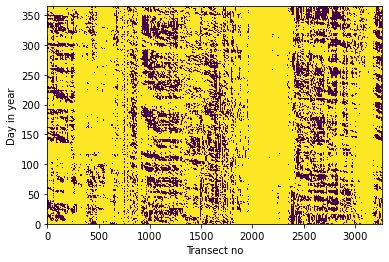

In [35]:
# Reversal occur with a high frequency, don't have a seasonal signal.
fig=plt.figure()
plt.pcolormesh(sign_sfc_btm.transpose())
plt.ylabel('Day in year')
plt.xlabel('Transect no');

Median

In [36]:
# Barotropic velocity
barotropic_0_median = np.where(ASC_regimes_binned==0, ds_barotropic.mean('depth_bin').mean('time'), np.nan)
barotropic_0_median = np.nanmedian(barotropic_0_median)
barotropic_1_median = np.where(ASC_regimes_binned==1, ds_barotropic.mean('depth_bin').mean('time'), np.nan)
barotropic_1_median = np.nanmedian(barotropic_1_median)
barotropic_2_median = np.where(ASC_regimes_binned==2, ds_barotropic.mean('depth_bin').mean('time'), np.nan)
barotropic_2_median = np.nanmedian(barotropic_2_median)
print(np.round(barotropic_0_median, 3), 'm/s')
print(np.round(barotropic_1_median, 3), 'm/s')
print(np.round(barotropic_2_median, 3), 'm/s')

-0.036 m/s
-0.049 m/s
0.013 m/s


In [37]:
# Bottom velocity
bottom_0_median = np.where(ASC_regimes_binned==0, ds_bottom.mean('depth_bin').mean('time'), np.nan)
bottom_0_median = np.nanmedian(bottom_0_median)
bottom_1_median = np.where(ASC_regimes_binned==1, ds_bottom.mean('depth_bin').mean('time'), np.nan)
bottom_1_median = np.nanmedian(bottom_1_median)
bottom_2_median = np.where(ASC_regimes_binned==2, ds_bottom.mean('depth_bin').mean('time'), np.nan)
bottom_2_median = np.nanmedian(bottom_2_median)
print(np.round(bottom_0_median, 3), 'm/s')
print(np.round(bottom_1_median, 3), 'm/s')
print(np.round(bottom_2_median, 3), 'm/s')

-0.008 m/s
-0.066 m/s
0.003 m/s


In [38]:
# Upper 200 m velocity
surface_200m_0_median = np.where(ASC_regimes_binned==0, ds_surface_200m.mean('depth_bin').mean('time'), np.nan)
surface_200m_0_median = np.nanmedian(surface_200m_0_median)
surface_200m_1_median = np.where(ASC_regimes_binned==1, ds_surface_200m.mean('depth_bin').mean('time'), np.nan)
surface_200m_1_median = np.nanmedian(surface_200m_1_median)
surface_200m_2_median = np.where(ASC_regimes_binned==2, ds_surface_200m.mean('depth_bin').mean('time'), np.nan)
surface_200m_2_median = np.nanmedian(surface_200m_2_median)
print(np.round(surface_200m_0_median, 3), 'm/s')
print(np.round(surface_200m_1_median, 3), 'm/s')
print(np.round(surface_200m_2_median, 3), 'm/s')

-0.082 m/s
-0.044 m/s
0.034 m/s


Standard deviation

In [39]:
# Barotropic velocity
barotropic_0_std = np.where(ASC_regimes_binned==0, ds_barotropic.mean('depth_bin').mean('time'), np.nan)
barotropic_0_std = np.nanstd(barotropic_0_std)
barotropic_1_std = np.where(ASC_regimes_binned==1, ds_barotropic.mean('depth_bin').mean('time'), np.nan)
barotropic_1_std = np.nanstd(barotropic_1_std)
barotropic_2_std = np.where(ASC_regimes_binned==2, ds_barotropic.mean('depth_bin').mean('time'), np.nan)
barotropic_2_std = np.nanstd(barotropic_2_std)
print(np.round(barotropic_0_std, 2), 'm/s')
print(np.round(barotropic_1_std, 2), 'm/s')
print(np.round(barotropic_2_std, 2), 'm/s')

0.02 m/s
0.03 m/s
0.03 m/s


In [40]:
# Bottom velocity
bottom_0_std = np.where(ASC_regimes_binned==0, ds_bottom.mean('depth_bin').mean('time'), np.nan)
bottom_0_std = np.nanstd(bottom_0_std)
bottom_1_std = np.where(ASC_regimes_binned==1, ds_bottom.mean('depth_bin').mean('time'), np.nan)
bottom_1_std = np.nanstd(bottom_1_std)
bottom_2_std = np.where(ASC_regimes_binned==2, ds_bottom.mean('depth_bin').mean('time'), np.nan)
bottom_2_std = np.nanstd(bottom_2_std)
print(np.round(bottom_0_std, 2), 'm/s')
print(np.round(bottom_1_std, 2), 'm/s')
print(np.round(bottom_2_std, 2), 'm/s')

0.01 m/s
0.04 m/s
0.02 m/s


In [41]:
# Upper 200 m velocity
surface_200m_0_std = np.where(ASC_regimes_binned==0, ds_surface_200m.mean('depth_bin').mean('time'), np.nan)
surface_200m_0_std = np.nanstd(surface_200m_0_std)
surface_200m_1_std = np.where(ASC_regimes_binned==1, ds_surface_200m.mean('depth_bin').mean('time'), np.nan)
surface_200m_1_std = np.nanstd(surface_200m_1_std)
surface_200m_2_std = np.where(ASC_regimes_binned==2, ds_surface_200m.mean('depth_bin').mean('time'), np.nan)
surface_200m_2_std = np.nanstd(surface_200m_2_std)
print(np.round(surface_200m_0_std, 2), 'm/s')
print(np.round(surface_200m_1_std, 2), 'm/s')
print(np.round(surface_200m_2_std, 2), 'm/s')

0.05 m/s
0.03 m/s
0.05 m/s


### Plotting infos

In [42]:
ft_size  = 22
fig_path = '/g/data/x77/wgh581/Figures/Figures_Binned/'

In [43]:
# Costum colormap
import matplotlib
colorsList_no4 = [('lightgreen'),('blueviolet'),('tomato'),('c')]
CustomCmap_no4 = matplotlib.colors.ListedColormap(colorsList_no4)
colorsList_no3 = [('lightgreen'),('blueviolet'),('tomato')]
CustomCmap_no3 = matplotlib.colors.ListedColormap(colorsList_no3)

### Annual average velocity plot

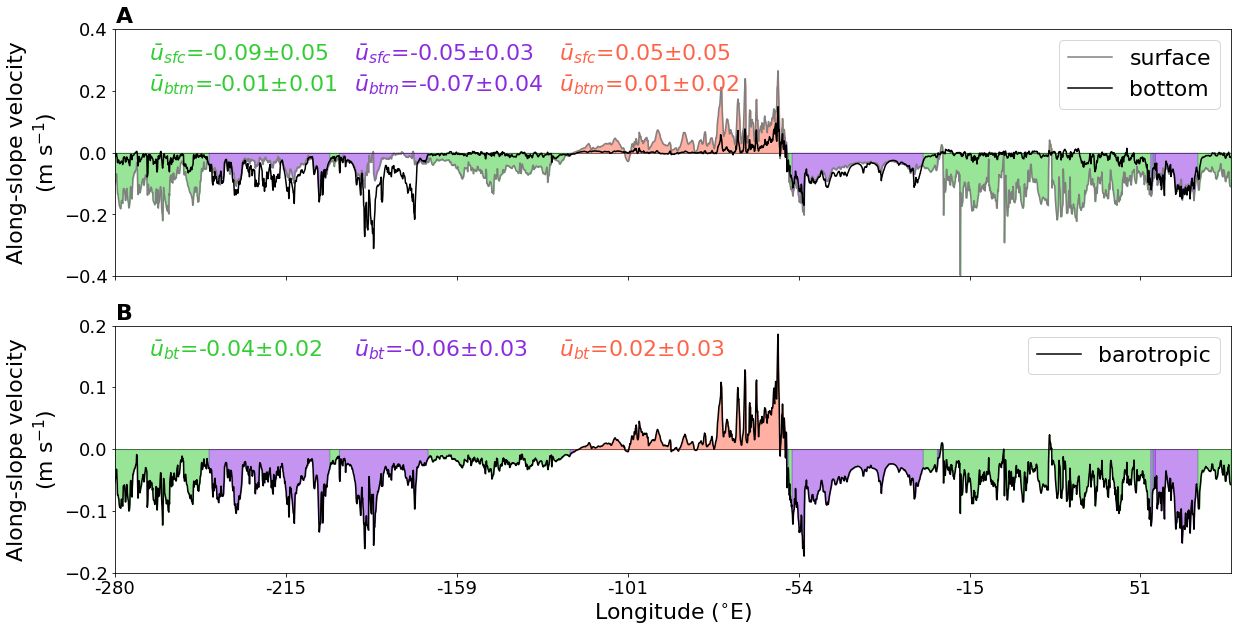

In [45]:
fig = plt.figure(figsize=(20,10))

# Surface (upper 200 m) and bottom velocity
plt.subplot(2,1,1)
plt.plot(ds_surface_200m.mean('depth_bin').mean('time'), label='surface', color='0.5')
plt.plot(ds_bottom.mean('depth_bin').mean('time'), label='bottom', color='k')
plt.legend(fontsize=ft_size)
for ii in range(len(ASC_tmp)):
    if ASC_tmp[ii] == 0:
        clr_tmp = 'limegreen'
    elif ASC_tmp[ii] == 1:
        clr_tmp = 'blueviolet'
    elif ASC_tmp[ii] == 2:
        clr_tmp = 'tomato'
    plt.fill_between(np.arange(index_tmp[ii], index_tmp[ii+1], 1), 0, ds_surface_200m.mean('depth_bin').mean('time')[index_tmp[ii]:index_tmp[ii+1]], color=clr_tmp, alpha=0.5)
plt.ylim(-0.4, 0.4)
plt.xlim(0, len(ds_surface.lon_shelf))
plt.title(r'$\bf{A}$', fontsize=ft_size, loc='left')
plt.ylabel('Along-slope velocity\n(m s$^{-1}$)', fontsize=ft_size)
plt.xticks(ticks=np.arange(0, len(ds.lon_shelf), 500), labels=ds.lon_shelf[::500].values.round())
plt.yticks(ticks=np.arange(-0.4, 0.5, 0.2))
plt.axhline(0, color='k', linewidth=0.5)
plt.tick_params(labelbottom=False, labelsize=ft_size-4) 
plt.text(100, 0.2, r'$\bar{u}_{btm}$=%.2f$\pm$%.2f'%(bottom_0, bottom_0_std), fontsize=ft_size, color='limegreen')
plt.text(700, 0.2, r'$\bar{u}_{btm}$=%.2f$\pm$%.2f'%(bottom_1, bottom_1_std), fontsize=ft_size, color='blueviolet')
plt.text(1300, 0.2, r'$\bar{u}_{btm}$=%.2f$\pm$%.2f'%(bottom_2, bottom_2_std), fontsize=ft_size, color='tomato')
plt.text(100, 0.3, r'$\bar{u}_{sfc}$=%.2f$\pm$%.2f'%(surface_200m_0, surface_200m_0_std), fontsize=ft_size, color='limegreen')
plt.text(700, 0.3, r'$\bar{u}_{sfc}$=%.2f$\pm$%.2f'%(surface_200m_1, surface_200m_1_std), fontsize=ft_size, color='blueviolet')
plt.text(1300, 0.3, r'$\bar{u}_{sfc}$=%.2f$\pm$%.2f'%(surface_200m_2, surface_200m_2_std), fontsize=ft_size, color='tomato')

# Barotropic velocity
plt.subplot(2,1,2)
plt.plot(ds_barotropic.mean('depth_bin').mean('time'), color='k', label='barotropic')
plt.legend(fontsize=ft_size)
for ii in range(len(ASC_tmp)):
    if ASC_tmp[ii] == 0:
        clr_tmp = 'limegreen'
    elif ASC_tmp[ii] == 1:
        clr_tmp = 'blueviolet'
    elif ASC_tmp[ii] == 2:
        clr_tmp = 'tomato'
    plt.fill_between(np.arange(index_tmp[ii], index_tmp[ii+1], 1), 0, ds_barotropic.mean('depth_bin').mean('time')[index_tmp[ii]:index_tmp[ii+1]], color=clr_tmp, alpha=0.5)
plt.ylim(-0.2, 0.2)
plt.xlim(0, len(ds_surface.lon_shelf))
plt.title(r'$\bf{B}$', fontsize=ft_size, loc='left')
plt.ylabel('Along-slope velocity\n(m s$^{-1}$)', fontsize=ft_size)
plt.xticks(ticks=np.arange(0, len(ds_surface.lon_shelf), 500), labels=ds_surface.lon_shelf[::500].values.round().astype(int))
plt.yticks(ticks=np.arange(-0.2, 0.3, 0.1))
plt.text(100, 0.15, r'$\bar{u}_{bt}$=%.2f$\pm$%.2f'%(barotropic_0, barotropic_0_std), fontsize=ft_size, color='limegreen')
plt.text(700, 0.15, r'$\bar{u}_{bt}$=%.2f$\pm$%.2f'%(barotropic_1, barotropic_1_std), fontsize=ft_size, color='blueviolet')
plt.text(1300, 0.15, r'$\bar{u}_{bt}$=%.2f$\pm$%.2f'%(barotropic_2, barotropic_2_std), fontsize=ft_size, color='tomato')
plt.axhline(0, color='k', linewidth=0.5)
plt.tick_params(labelsize=ft_size-4)  
plt.xlabel('Longitude ($^{\circ}$E)', fontsize=ft_size)

# Finished
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_binned_sfc_btm_btr.png'
    plt.savefig(fig_path + fig_name, dpi=150, bbox_inches='tight', facecolor='white')

### Hovmoller plot (daily data)

Prepare infos to add lines of propagation velocity

In [46]:
# Wind signal in surface velocity
x_wind = [500, 1500]
y_wind = [150, 0]
# Update second y entry given our assumed velocity signal
V = (np.round(distance_along_contour_cumsum[-1])) / (23)  # km/day
V_wind = int(np.round(V, 0))
print(V_wind)
L = distance_along_contour_cumsum[x_wind[1]] - distance_along_contour_cumsum[x_wind[0]]  # in km
y_wind[1] = y_wind[0] + L/V  # in day

# Fast signal in barotropic velocity
x_green = [1000, 2700]
y_green = [0, 200]
# Update second y entry given our assumed velocity signal
V = (np.round(distance_along_contour_cumsum[-1])) / (73)  # km/day
L = distance_along_contour_cumsum[x_green[0]] - distance_along_contour_cumsum[x_green[1]]  # in km
y_green[0] = y_green[1] - L/V  # in day

# Barotropic velocity for different regimes
x_line = [2730, 2670, 770, 700, 1860, 1930]
y_line = [75, 150, 150, 175, 250, 350]
# Update second y entry given our assumed velocity signal
Y_end = np.zeros(3)
for ii in range(len(Y_end)):
    L = (distance_along_contour_cumsum[x_line[ii*2+1]] - distance_along_contour_cumsum[x_line[ii*2]])  # in km
    if ii == 0 :
        V = ds_barotropic.mean('depth_bin')[x_line[ii*2+1]:x_line[ii*2], y_line[ii*2]:y_line[ii*2+1]] # in m/s
    if ii == 1 :
        V = ds_bottom.mean('depth_bin')[x_line[ii*2+1]:x_line[ii*2], y_line[ii*2]:y_line[ii*2+1]] # in m/s
    elif ii > 1:
        V = ds_barotropic.mean('depth_bin')[x_line[ii*2]:x_line[ii*2+1], y_line[ii*2]:y_line[ii*2+1]] # in m/s
    V = np.nanmean(V)
    V = V / 1000 * 3600*24   # in km/day
    if ii == 0:
        V_barotropic_EA = int(np.round(V, 0))
    elif ii == 1:
        V_bottom = int(np.round(V, 0))
    elif ii == 2:
        V_barotropic_AAP = int(np.round(V, 0))
    print(V)
    Y_end[ii] = y_line[ii*2] + L/V

line_name = ['Barotropic', 'Bottom', 'Barotropic']

867
-5.619491427922933
-12.521411235597748
6.239406986959091


In [47]:
# Black line velocity
L = ( distance_along_contour_cumsum[1700] - distance_along_contour_cumsum[1000] ) * 1000  # in m
T = (120-40) * 24*3600 # in s
V_black = L/T
V_black = V_black * 1/1000 * 24*3600
V_black = int(np.round(V_black, 0))

In [48]:
print(V_black)
print(L)
print(T)
L/T

41
3296071.294452364
6912000


0.476862166442761

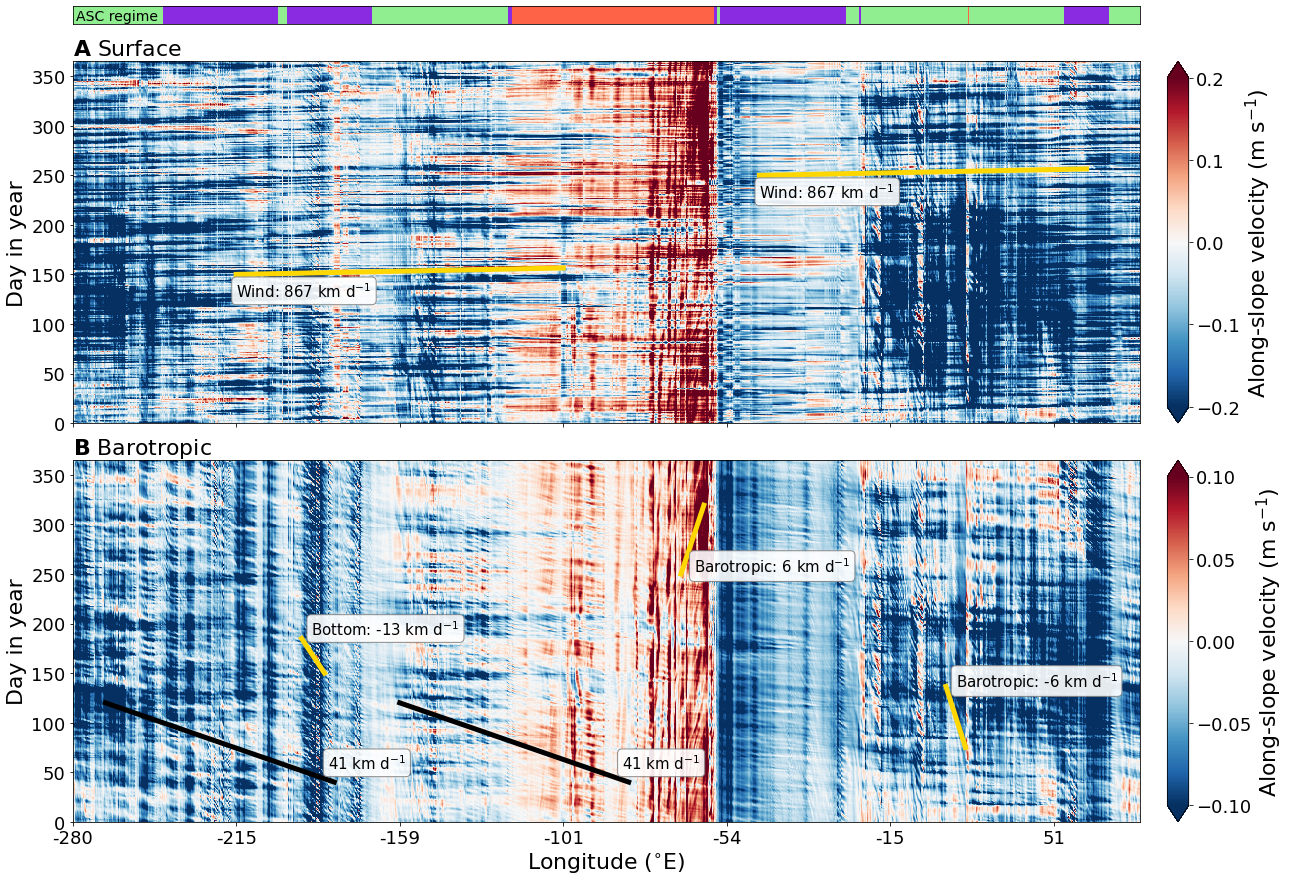

In [54]:
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)

gs  = gridspec.GridSpec(3, 2, height_ratios=[0.05, 1, 1], hspace=0.15, width_ratios=[1, 0.02], wspace=0.05)

fig = plt.figure(figsize=(20, 15))

# ASC bar
ax = fig.add_subplot(gs[0,0])
plt.pcolormesh(np.arange(3264), [0,1], ASC_regimes_binned_2d, cmap=CustomCmap_no3)
#plt.pcolormesh(np.arange(4487), [0,1], ASC_regimes_2d, cmap=CustomCmap_no3)
ax.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)
plt.text(10, 0.25, 'ASC regime', fontsize=ft_size-8)

for ii in range(2):
    
    ax = fig.add_subplot(gs[ii+1,0])
    
    if ii==0:
        # Surface
        sc = plt.pcolormesh(ds_surface.mean('depth_bin').transpose(), vmin=-0.2, vmax=0.2, cmap='RdBu_r')
        plt.title(r'$\bf{A}$ Surface', fontsize=ft_size, loc='left')
        ax.tick_params(labelbottom=False)
        # Line of surface wind signal
        plt.plot(x_wind, y_wind, 'gold', linewidth=5)
        plt.plot([a+1600 for a in x_wind], [a+100 for a in y_wind], 'gold', linewidth=5)
        # Text to label line
        plt.text(x_wind[0], y_wind[0]-26, 'Wind: %i km d$^{-1}$'%V_wind, color='k', fontsize=ft_size-7, fontweight='normal', ha="left", va="bottom", bbox=bbox_props)
        plt.text(x_wind[0]+1600, y_wind[0]+100-26, 'Wind: %i km d$^{-1}$'%V_wind, color='k', fontsize=ft_size-7, fontweight='normal', ha="left", va="bottom", bbox=bbox_props)
        
    elif ii==1:
        # Barotropic
        SC = plt.pcolormesh(ds_barotropic.mean('depth_bin').transpose(), vmin=-0.1, vmax=0.1, cmap='RdBu_r')
        plt.title(r'$\bf{B}$ Barotropic', fontsize=ft_size, loc='left')
        plt.xlabel('Longitude ($^{\circ}$E)', fontsize=ft_size)
        # Lines of advection speed + label line
        for tt in range(3):
            plt.plot([x_line[tt*2], x_line[tt*2+1]], [y_line[tt*2], Y_end[tt]], color='gold', linewidth=5)
            # Text to label line
            if tt == 2:
                plt.text(x_line[tt*2]+40, y_line[tt*2]+8, line_name[tt] + ': %i km d$^{-1}$'%V_barotropic_AAP, fontsize=ft_size-7, color='k', fontweight='normal', ha="left", va="center", bbox=bbox_props)
            elif tt == 0:
                plt.text(x_line[tt*2+1]+30, y_line[tt*2+1]-8, line_name[tt] + ': %i km d$^{-1}$'%V_barotropic_EA, fontsize=ft_size-7, color='k', fontweight='normal', ha="left", va="center", bbox=bbox_props)
            elif tt == 1:
                plt.text(x_line[tt*2+1]+30, y_line[tt*2+1]+20, line_name[tt] + ': %i km d$^{-1}$'%V_bottom, fontsize=ft_size-7, color='k', fontweight='normal', ha="left", va="center", bbox=bbox_props)
        # Add black slopes to indicate other time scales of signal propagation around the continental slope
        plt.plot([1700, 1000], [40, 120], 'k', linewidth=5)
        plt.plot([800, 100], [40, 120], 'k', linewidth=5)
        plt.text(800-20, 40+10, '%i km d$^{-1}$'%V_black, color='k', fontsize=ft_size-7, fontweight='normal', ha="left", va="bottom", bbox=bbox_props)
        plt.text(1700-20, 40+10, '%i km d$^{-1}$'%V_black, color='k', fontsize=ft_size-7, fontweight='normal', ha="left", va="bottom", bbox=bbox_props)
                
    plt.ylim(0, 365)
    plt.xticks(fontsize=ft_size-4)
    plt.yticks(fontsize=ft_size-4)
    plt.xticks(ticks=np.arange(0, len(ds_surface.lon_shelf), 500), labels=ds_surface.lon_shelf[::500].values.round().astype(int))
    plt.ylabel('Day in year', fontsize=ft_size)

# Colorbar
cbar_ax = fig.add_subplot(gs[1,-1])
cbar = plt.colorbar(sc, cax=cbar_ax, extend='both', ticks=np.arange(-0.2, 0.3, 0.1))
cbar.set_label('Along-slope velocity (m s$^{-1}$)', fontsize=ft_size)
cbar.ax.tick_params(labelsize=ft_size-4)
cbar_ax = fig.add_subplot(gs[2,-1])
cbar = plt.colorbar(SC, cax=cbar_ax, extend='both', ticks=np.arange(-0.1, 0.15, 0.05))
cbar.set_label('Along-slope velocity (m s$^{-1}$)', fontsize=ft_size)
cbar.ax.tick_params(labelsize=ft_size-4)

# Finished
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_hovmoeller_daily_sfc_btr.png'
    plt.savefig(fig_path + fig_name, dpi=150, bbox_inches='tight', facecolor='white')

---
Plot anomaly (annual mean)

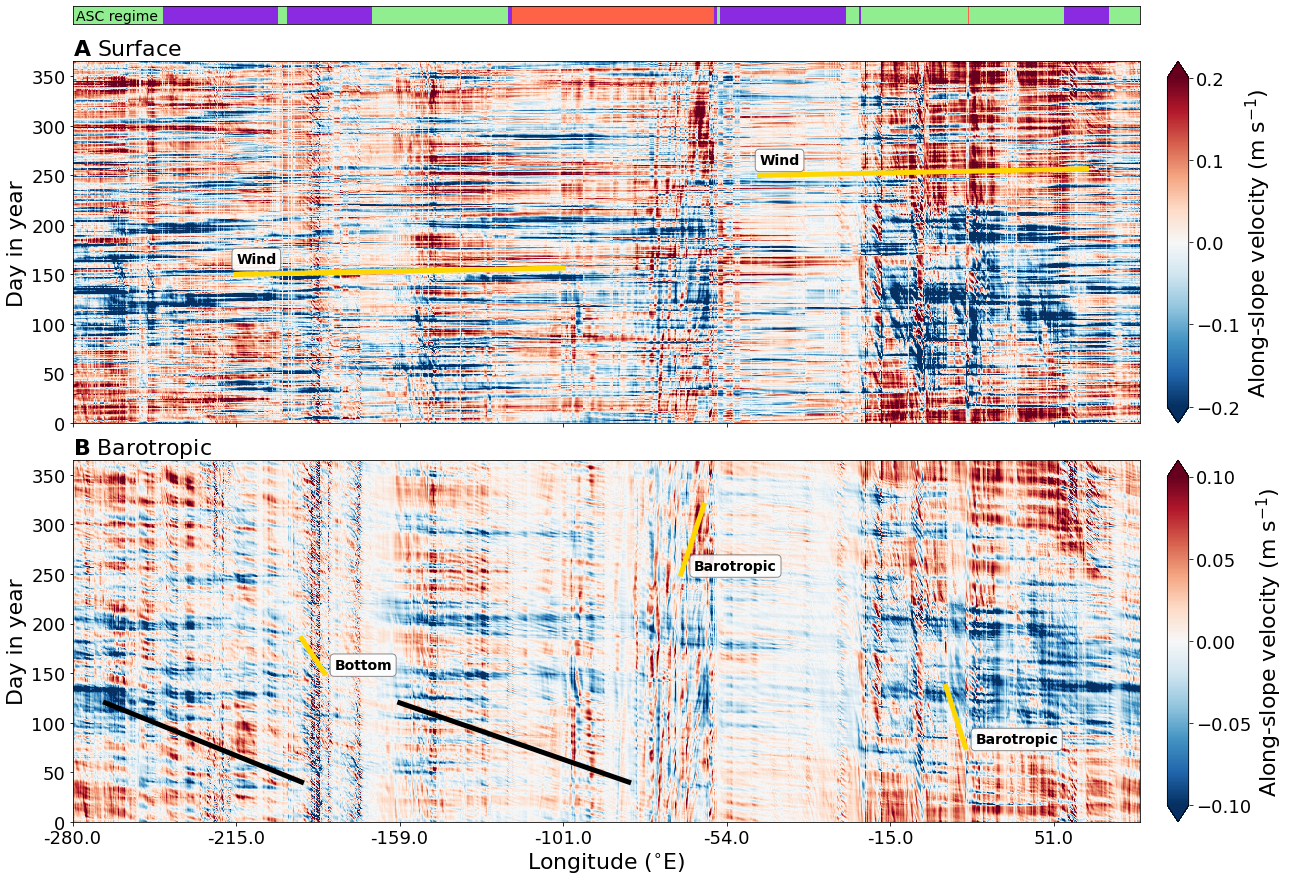

In [46]:
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)

gs  = gridspec.GridSpec(3, 2, height_ratios=[0.05, 1, 1], hspace=0.15, width_ratios=[1, 0.02], wspace=0.05)

fig = plt.figure(figsize=(20, 15))

# ASC bar
ax = fig.add_subplot(gs[0,0])
plt.pcolormesh(np.arange(3264), [0,1], ASC_regimes_binned_2d, cmap=CustomCmap_no3)
ax.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)
plt.text(10, 0.25, 'ASC regime', fontsize=ft_size-8)

for ii in range(2):
    
    ax = fig.add_subplot(gs[ii+1,0])
    
    if ii==0:
        # Surface
        sc = plt.pcolormesh(ds_surface.mean('depth_bin').transpose()-ds_surface.mean('depth_bin').mean('time'), vmin=-0.2, vmax=0.2, cmap='RdBu_r')
        plt.title(r'$\bf{A}$ Surface', fontsize=ft_size, loc='left')
        ax.tick_params(labelbottom=False)
        # Line of surface wind signal
        plt.plot(x_wind, y_wind, 'gold', linewidth=5)
        plt.plot([a+1600 for a in x_wind], [a+100 for a in y_wind], 'gold', linewidth=5)
        # Text to label line
        plt.text(x_wind[0], y_wind[0]+8, 'Wind', color='k', fontsize=ft_size-8, fontweight='bold', ha="left", va="bottom", bbox=bbox_props)
        plt.text(x_wind[0]+1600, y_wind[0]+100+8, 'Wind', color='k', fontsize=ft_size-8, fontweight='bold', ha="left", va="bottom", bbox=bbox_props)
        
    elif ii==1:
        # Barotropic
        SC = plt.pcolormesh(ds_barotropic.mean('depth_bin').transpose()-ds_barotropic.mean('depth_bin').mean('time'), vmin=-0.1, vmax=0.1, cmap='RdBu_r')
        plt.title(r'$\bf{B}$ Barotropic', fontsize=ft_size, loc='left')
        plt.xlabel('Longitude ($^{\circ}$E)', fontsize=ft_size)
        # Lines of advection speed + label line
        for tt in range(3):
            plt.plot([x_line[tt*2], x_line[tt*2+1]], [y_line[tt*2], Y_end[tt]], color='gold', linewidth=5)
            # Text to label line
            if tt == 2:
                plt.text(x_line[tt*2]+40, y_line[tt*2]+8, line_name[tt], fontsize=ft_size-8, color='k', fontweight='bold', ha="left", va="center", bbox=bbox_props)
            else:
                plt.text(x_line[tt*2]+30, y_line[tt*2]+8, line_name[tt], fontsize=ft_size-8, color='k', fontweight='bold', ha="left", va="center", bbox=bbox_props)
        # Add black slopes to indicate other time scales of signal propagation around the continental slope
        plt.plot([1700, 1000], [40, 120], 'k', linewidth=5)
        plt.plot([700, 100], [40, 120], 'k', linewidth=5)
        # FIX, ONE IS 600 long, the other 700
                
    plt.ylim(0, 365)
    plt.xticks(fontsize=ft_size-4)
    plt.yticks(fontsize=ft_size-4)
    plt.xticks(ticks=np.arange(0, len(ds_surface.lon_shelf), 500), labels=ds_surface.lon_shelf[::500].values.round())
    plt.ylabel('Day in year', fontsize=ft_size)

# Colorbar
cbar_ax = fig.add_subplot(gs[1,-1])
cbar = plt.colorbar(sc, cax=cbar_ax, extend='both', ticks=np.arange(-0.2, 0.3, 0.1))
cbar.set_label('Along-slope velocity (m s$^{-1}$)', fontsize=ft_size)
cbar.ax.tick_params(labelsize=ft_size-4)
cbar_ax = fig.add_subplot(gs[2,-1])
cbar = plt.colorbar(SC, cax=cbar_ax, extend='both', ticks=np.arange(-0.1, 0.15, 0.05))
cbar.set_label('Along-slope velocity (m s$^{-1}$)', fontsize=ft_size)
cbar.ax.tick_params(labelsize=ft_size-4)

# Finished
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_hovmoeller_daily_sfc_btr_anomaly.png'
    plt.savefig(fig_path + fig_name, dpi=150, bbox_inches='tight', facecolor='white')